In [1]:
# import dontenv, cargar las variables de entorno y mostrar OPENAI_API_KEY Y TAVILY_API_KEY
import dotenv

dotenv.load_dotenv()

True

[StructuredTool(name='add', description='Add two numbers', args_schema={'properties': {'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}, 'required': ['a', 'b'], 'title': 'addArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x110b5b640>), StructuredTool(name='multiply', description='Multiply two numbers', args_schema={'properties': {'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}, 'required': ['a', 'b'], 'title': 'multiplyArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x110b5b6d0>), StructuredTool(name='buscar_contratos_por_ruc', args_schema={'properties': {'ruc': {'title': 'Ruc', 'type': 'string'}}, 'required': ['ruc'], 'title': 'buscar_contratos_por_rucArguments', 'type': 'object'}, response_format='content_and_artifact', coro

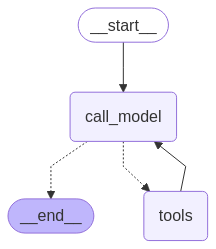

In [5]:
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langgraph.graph import END
from langchain_community.tools.tavily_search import TavilySearchResults

model = ChatOpenAI(model="gpt-4o")

async def main():
    async with MultiServerMCPClient(
        {
            "math": {
                "command": "python",
                "args": ["./math_server.py"],
                "transport": "stdio",
            },
            "weather": {
                "url": "http://localhost:8000/sse",
                "transport": "sse",
            }
        }
    ) as client:
        tavily_tool = TavilySearchResults(max_results=2)
        tools = client.get_tools() + [tavily_tool]
        print(tools)    

        def call_model(state: MessagesState):
            response = model.bind_tools(tools).invoke(state["messages"])
            return {"messages": response}

        builder = StateGraph(MessagesState)
        builder.add_node("call_model", call_model)
        builder.add_node("tools", ToolNode(tools))

        builder.add_edge(START, "call_model")
        builder.add_conditional_edges("call_model", tools_condition)
        builder.add_edge("tools", "call_model")
        builder.add_edge("call_model", END)

        graph = builder.compile()

        

        display(Image(graph.get_graph().draw_mermaid_png()))


        return graph  # 👈 retornar grafo compilado

# Ejecuta esto en una celda
graph = await main()

In [6]:
agent_response = await graph.ainvoke({"messages": "what's 10 x 2 + 5?"})
for msg in agent_response["messages"]:
    print(msg.pretty_print())

================================ Human Message =================================

what's 10 x 2 + 5?
None
================================== Ai Message ==================================
Tool Calls:
  multiply (call_KQFALR1Zsj24A9TD3wi99zut)
 Call ID: call_KQFALR1Zsj24A9TD3wi99zut
  Args:
    a: 10
    b: 2
  add (call_haBA1oI7qOnCyEj3tEZwf5Hs)
 Call ID: call_haBA1oI7qOnCyEj3tEZwf5Hs
  Args:
    a: 20
    b: 5
None
================================= Tool Message =================================
Name: multiply

Error: ClosedResourceError()
 Please fix your mistakes.
None
================================= Tool Message =================================
Name: add

Error: ClosedResourceError()
 Please fix your mistakes.
None
================================== Ai Message ==================================

It seems there's an issue with processing both the multiplication and addition in parallel. Let me calculate it for you directly:

1. Multiply 10 by 2:
   - \( 10 \times 2 = 20 \)

2. Add 

In [4]:
await graph.ainvoke({"messages": "what's the weather in Cusco?"})

{'messages': [HumanMessage(content="what's the weather in Cusco?", additional_kwargs={}, response_metadata={}, id='4246be50-a19f-4865-8a8f-473b7ced1ebc'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_uzZKaTdbQeciJzxKKnyBfV8l', 'function': {'arguments': '{"query":"Cusco weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 187, 'total_tokens': 208, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'id': 'chatcmpl-BUwsbfdAq3uuFI75C9Ow4wlXde03H', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--dd3d1fe1-9869-42ef-95b6-ad8fa4925dbf-0', tool_calls=[{'name': 'tavily_search_results_json', 'arg